# 2023-03-03

### Read Data

In [1]:
!pip install -U finance-datareader


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [68]:
df = fdr.DataReader('AAPL', '2018')[['Close']]
df

,Close
Date,
2018-01-02,43.064999
2018-01-03,43.057499
2018-01-04,43.257500
2018-01-05,43.750000
2018-01-08,43.587502
...,...
2023-02-24,146.710007
2023-02-27,147.919998
2023-02-28,147.410004


In [69]:
print(df.index.max())
print(df.index.min())

2023-03-02 00:00:00
2018-01-02 00:00:00


<AxesSubplot: xlabel='Date'>

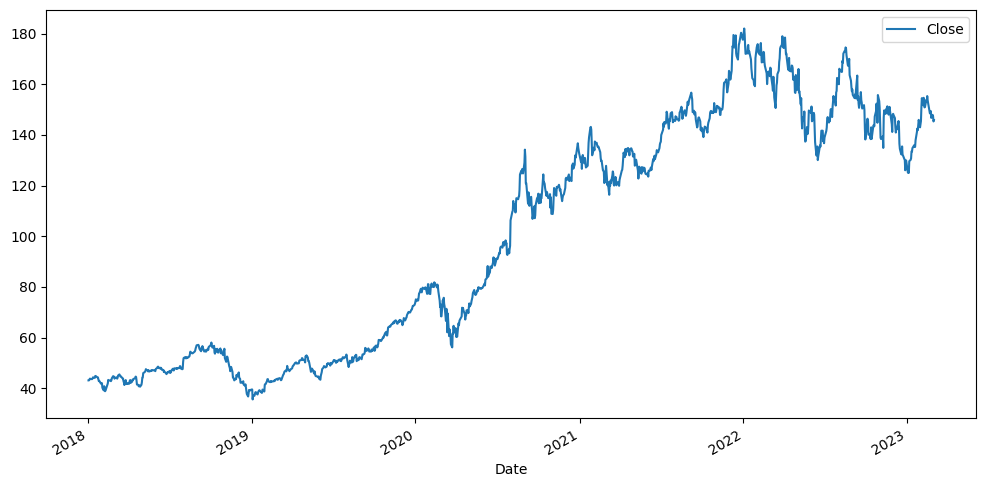

In [70]:
df.plot(figsize=(12, 6))

In [6]:
df.shape

(1300, 1)

In [71]:
# train / test split

test_size = 300
split_idx = len(df) - test_size

train = df.iloc[:split_idx]
test = df.iloc[split_idx:]
print(train.shape)
print(test.shape)

(1000, 1)
(300, 1)


In [72]:
# scaling

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [85]:
# TimeseriesGenerator
import tensorflow as tf

window_size = 20              

train_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_train, scaled_train, length = window_size, batch_size = 1)
test_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_test, scaled_test, length = window_size, batch_size = 1)

In [86]:
# modeling(compile, fit)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(40, activation = 'relu', input_shape = (window_size, 1)))   # feature가 1개
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 40)                6720      
                                                                 
 dense_5 (Dense)             (None, 1)                 41        
                                                                 
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.fit(train_gen, epochs = 40)

Epoch 1/40
980/980 [==============================] - 6s 5ms/step - loss: 0.0070
Epoch 2/40
980/980 [==============================] - 5s 5ms/step - loss: 8.0965e-04
Epoch 3/40
980/980 [==============================] - 5s 5ms/step - loss: 6.6944e-04
Epoch 4/40
980/980 [==============================] - 5s 5ms/step - loss: 4.6806e-04
Epoch 5/40
980/980 [==============================] - 5s 5ms/step - loss: 4.7433e-04
Epoch 6/40
980/980 [==============================] - 5s 5ms/step - loss: 4.2682e-04
Epoch 7/40
980/980 [==============================] - 5s 5ms/step - loss: 3.8794e-04
Epoch 8/40
980/980 [==============================] - 5s 5ms/step - loss: 4.0347e-04
Epoch 9/40
980/980 [==============================] - 5s 5ms/step - loss: 3.1969e-04
Epoch 10/40
980/980 [==============================] - 5s 5ms/step - loss: 3.0454e-04
Epoch 11/40
980/980 [==============================] - 5s 5ms/step - loss: 3.0521e-04
Epoch 12/40
980/980 [==============================] - 5s 5ms/step 

In [88]:
batch = scaled_train[-20:].reshape(1, window_size, 1)

In [89]:
model.predict(batch) 

1/1 [==============================] - 0s 136ms/step


array([[0.92191917]], dtype=float32)

In [90]:
scaled_test[0]

array([0.95510855])

In [91]:
scaled_train[-20:]

array([[0.87192722],
       [0.87463739],
       [0.87832042],
       [0.84267126],
       [0.86650689],
       [0.90166957],
       [0.89798653],
       [0.89096783],
       [0.87762547],
       [0.90180858],
       [0.9425305 ],
       [0.96963225],
       [0.96601866],
       [1.        ],
       [0.97421871],
       [0.96442039],
       [0.99895767],
       [0.9500356 ],
       [0.94225258],
       [0.93259327]])

In [92]:
import numpy as np

batch2 = np.append(scaled_train[-19:], [scaled_test[0]])
batch2.shape
print(batch2)

[0.87463739 0.87832042 0.84267126 0.86650689 0.90166957 0.89798653
 0.89096783 0.87762547 0.90180858 0.9425305  0.96963225 0.96601866
 1.         0.97421871 0.96442039 0.99895767 0.9500356  0.94225258
 0.93259327 0.95510855]


In [94]:
batch = scaled_train[-20:].reshape(1, window_size, 1)
predict_result = []
for test_values in scaled_test[:, 0]:
    prediction = model.predict(batch)[0]                                            # 예측 결과가 array형태라 value만 선택하기 위해
    predict_result.append(prediction)
    batch = np.append(batch[0, -19:], [prediction]).reshape(1, window_size, 1)
predict_result = np.array(predict_result)

1/1 [==============================] - 0s 19ms/step


In [95]:
inverse_prediction_data = scaler.inverse_transform(predict_result)

In [96]:
test['Model_Pred'] = inverse_prediction_data.copy()
test

C:\Users\GM220808\AppData\Local\Temp\ipykernel_5460\3877053230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Model_Pred'] = inverse_prediction_data.copy()


,Close,Model_Pred
Date,,
2021-12-21,172.990005,168.213974
2021-12-22,175.639999,166.734085
2021-12-23,176.279999,165.310699
2021-12-27,180.330002,163.933746
2021-12-28,179.289993,162.597214
...,...,...
2023-02-24,146.710007,36.414875
2023-02-27,147.919998,36.413910
2023-02-28,147.410004,36.413097


<AxesSubplot: xlabel='Date'>

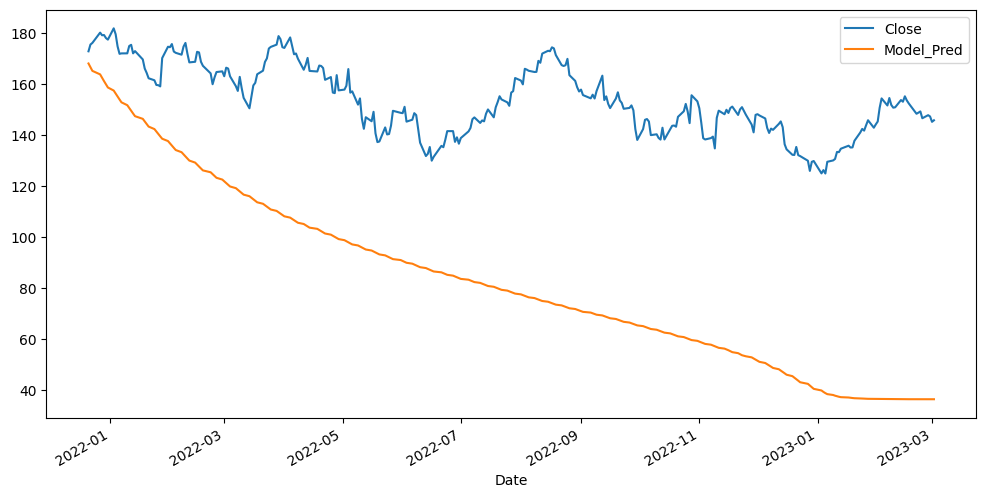

In [97]:
test.plot(figsize=(12, 6))                # ov

## 다변량 시계열 모델

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [102]:
df = pd.read_csv('energydata_complete.csv', index_col = 'date', parse_dates = True)
df.head(3)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


In [103]:
df.shape

(19735, 28)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

<AxesSubplot: xlabel='date'>

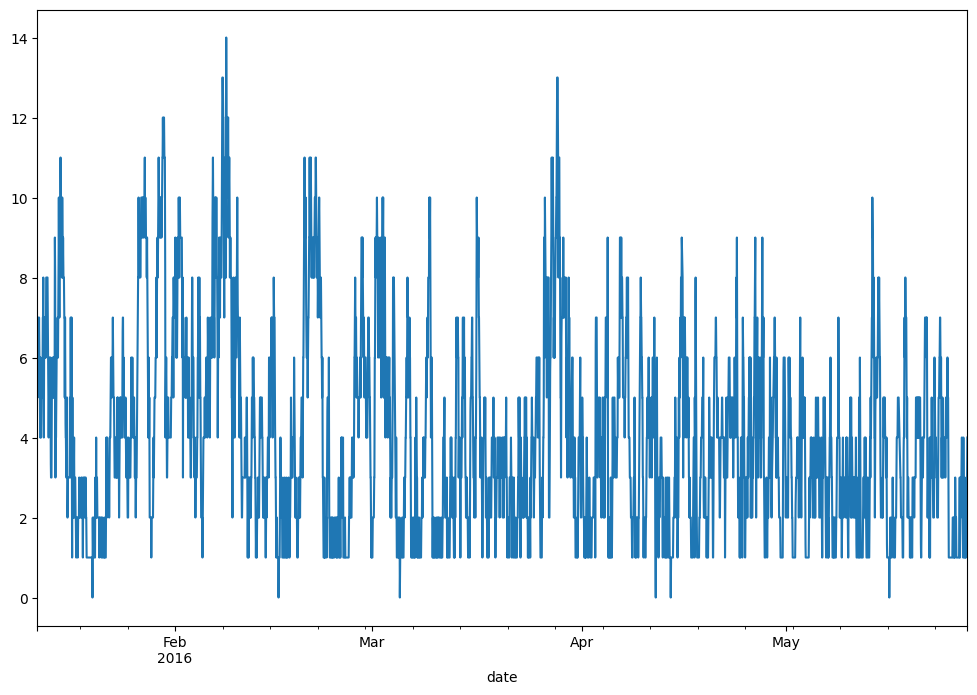

In [109]:
df['Windspeed'].plot(figsize=(12, 8))

<AxesSubplot: xlabel='date'>

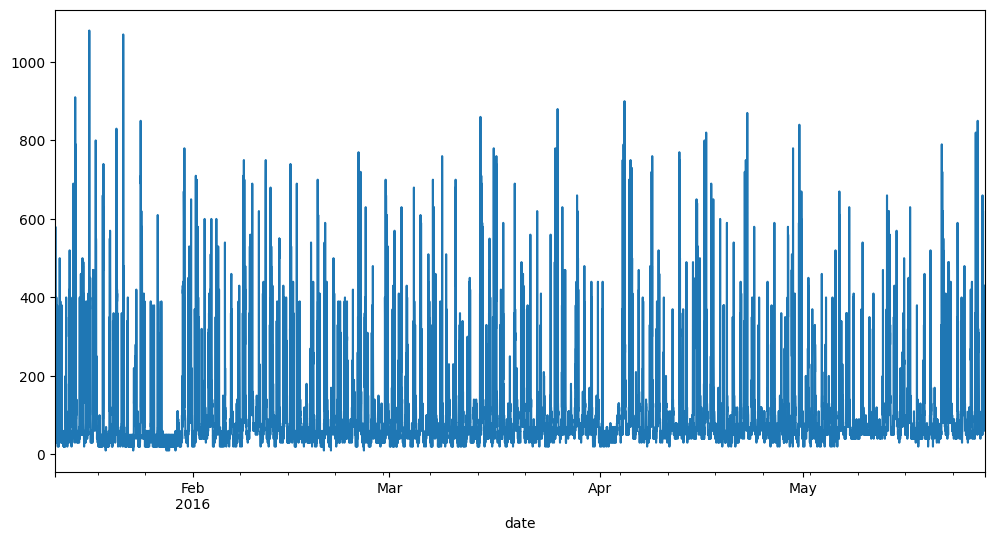

In [110]:
df['Appliances'].plot(figsize=(12, 6))

## train/test split

In [111]:
df.shape

(19735, 28)

In [122]:
# 하루에 데이터가 몇 줄인가?
DATA_FREQ = 10
DAY_HOUR = 24
DAY_MIN = 60
DAY_ROW_COUNT = int(DAY_HOUR * DAY_MIN / DATA_FREQ)
DAY_ROW_COUNT

144

In [116]:
TEST_DAYS = 5

In [118]:
SPLIT_IDX = int(DAY_ROW_COUNT * TEST_DAYS)

In [120]:
train = df.iloc[:-SPLIT_IDX]
test = df.iloc[-SPLIT_IDX:]

print(train.shape)
print(test.shape)

(19015, 28)
(720, 28)


## scaling

In [121]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [123]:
# TimeSeriesGenerator
import tensorflow as tf

window_size = DAY_ROW_COUNT               
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_train, scaled_train, length = window_size, batch_size = 1)

In [124]:
len(generator)

18871

In [125]:
X, y = generator[0]
print(X)
print(y)

[[[0.04672897 0.42857143 0.32734952 ... 0.53846154 0.26544891 0.26544891]
  [0.04672897 0.42857143 0.32734952 ... 0.53393665 0.37208289 0.37208289]
  [0.03738318 0.42857143 0.32734952 ... 0.52941176 0.57284766 0.57284766]
  ...
  [0.02803738 0.         0.34952482 ... 0.42986425 0.60154056 0.60154056]
  [0.02803738 0.         0.34952482 ... 0.42081448 0.23880424 0.23880424]
  [0.02803738 0.         0.34952482 ... 0.41176471 0.25810488 0.25810488]]]
[[0.04672897 0.         0.34600493 0.4350977  0.21080688 0.61734507
  0.21518777 0.74466428 0.37477477 0.63593683 0.21691352 0.31703589
  0.35574637 0.76737445 0.25908472 0.5214736  0.20994812 0.55483208
  0.22996878 0.58333333 0.36977492 0.34651163 0.67105263 0.5
  0.43076923 0.40271493 0.72933144 0.72933144]]


## modeling

In [129]:
window_size

144

In [128]:
n_features = scaled_train.shape[1]
n_features

28

In [130]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(100, input_shape = (window_size, n_features)))   
model.add(Dense(n_features))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               51600     
                                                                 
 dense_6 (Dense)             (None, 28)                2828      
                                                                 
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________


In [145]:
# validation (scaled_test)

validation_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_test, scaled_test, length = window_size, batch_size = 1)

In [147]:
# EarlyStopping (특정 조건을 걸어놓고 조건에 부합하면 모델을 stop시키는 방법)

from tensorflow.keras.callbacks import EarlyStopping
ealry_stop = EarlyStopping(monitor = 'val_loss', patience = 1)    # patience = 성능이 증가하지 않는 epoch를 허용할 횟수

In [146]:
model.fit(generator, epochs = 3, validation_data = validation_generator, 
         callbacks = [early_stop])

Epoch 1/3
16066/18871 [========================>.....] - ETA: 1:33 - loss: 0.0067

KeyboardInterrupt: 

### evaluate(prediction)

In [135]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

In [143]:
losses = pd.DataFrame(model.history.history)
losses

,loss,val_loss
0,0.007027,0.007069


<AxesSubplot: >

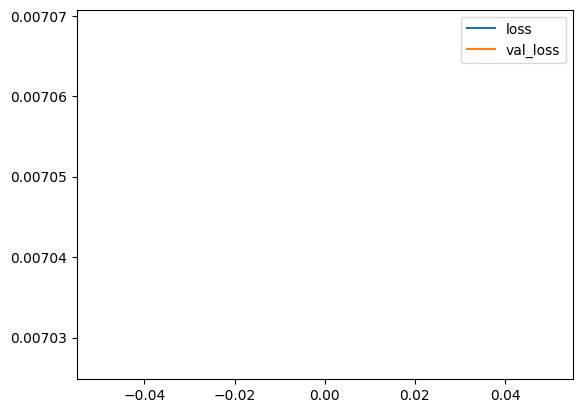

In [144]:
losses.plot()

In [ ]:
batch = scaled_train[-window_size:].reshape(1, window_size, n_features)
predict_result = []
for test_value in scaled_test[:, 0]:
    prediction = model.predict(batch)[0]
    predict_result.append(prediction)
    batch = np.append(batch[:, 1:, :], [prediction]).reshape(1, window_size, n_features)
predict_result = np.array(predict_result)

In [ ]:
inverse_prediction_data = scaler.inverse_transform(predict_result)

In [ ]:
prediction_df = pd.DataFrame(inverse_prediction_data, columns = test.columns)